# EDA

To analyze this properly, we will need longitude and latitudes, to do this, we will need a shapefile. I have included the final CSV, however if you are interested you can get the shape file from [here](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip) and use [this](https://disq.us/url?url=https%3A%2F%2Fmygeodata.cloud%2Fconverter%2Fshp-to-latlong%29%3APxLSP7AjU7-LLKjz3b1k2lZO5fc&cuid=5002428) to convert it to a usable form with proper coordinates.

In [14]:
# to get the df
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

df_loc.to_csv("zones.csv")

In [8]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
plt.style.use("ggplot")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import shapefile

In [ ]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-06.parquet

### Enriching with geo-data

In [82]:
df_loc = pd.read_csv('shape.csv')

In [83]:
df_loc

,LocationID,borough,longitude,latitude
0,1,EWR,-74.172,40.689
1,2,Queens,-73.822,40.611
2,3,Bronx,-73.845,40.866
3,4,Manhattan,-73.978,40.724
4,5,Staten Island,-74.188,40.551
...,...,...,...,...
266,259,Bronx,-73.856,40.899
267,260,Queens,-73.907,40.747
268,261,Manhattan,-74.013,40.709
269,262,Manhattan,-73.945,40.777


In [681]:
df = pd.read_parquet('yellow_tripdata_2022-06.parquet')
df = df.sample(frac=0.05)

In [37]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1588209,1,2022-06-14 17:25:43,2022-06-14 17:59:44,2.000,2.900,1.000,N,249,264,2,20.500,3.500,0.500,0.000,0.000,0.300,24.800,2.500,0.000
2075258,2,2022-06-18 17:43:17,2022-06-18 17:54:09,1.000,1.870,1.000,N,239,237,1,9.500,0.000,0.500,2.560,0.000,0.300,15.360,2.500,0.000
2273847,1,2022-06-20 17:57:51,2022-06-20 18:01:29,4.000,0.600,1.000,N,113,234,2,4.500,3.500,0.500,0.000,0.000,0.300,8.800,2.500,0.000
61397,2,2022-06-01 15:54:59,2022-06-01 16:11:55,1.000,2.010,1.000,N,238,237,2,12.000,0.000,0.500,0.000,0.000,0.300,15.300,2.500,0.000
2125429,2,2022-06-19 02:06:21,2022-06-19 02:10:29,2.000,1.000,1.000,N,264,264,2,5.000,0.500,0.500,0.000,0.000,0.300,8.800,2.500,0.000


In [125]:
def ny_taxi_geo_merger(df1, df2):
    df_merge = pd.merge(df1, df2, how="left", left_on=['PULocationID'], right_on=['LocationID'] )
    df_merge.rename(columns = {"longitude": "pickup_long", "latitude":'pickup_lat' }, 
          inplace = True)
    df_merge.drop(['LocationID','PULocationID','borough'], axis=1, inplace=True)
    df_merge = pd.merge(df_merge, df2, how="left", left_on=['DOLocationID'], right_on=['LocationID'] )
    df_merge.rename(columns = {"longitude": "dropoff_long", "latitude":'dropoff_lat' }, 
          inplace = True)
    df_merge.drop(['LocationID','DOLocationID', 'borough'], axis=1, inplace=True)
    return df_merge

In [129]:
def distance(s_lat, s_lng, e_lat, e_lng):

   # approximate radius of earth in km
   R = 6373.0

   s_lat = s_lat*np.pi/180.0                      
   s_lng = np.deg2rad(s_lng)     
   e_lat = np.deg2rad(e_lat)                       
   e_lng = np.deg2rad(e_lng)  

   d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

   return 2 * R * np.arcsin(np.sqrt(d))

In [659]:
def add_distances_from_airport(df):
    #coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    df['pickup_jfk_distance'] = distance(jfk_coords[0], jfk_coords[1], df.pickup_lat, df.pickup_long)
    df['dropoff_jfk_distance'] = distance(jfk_coords[0], jfk_coords[1], df.dropoff_lat, df.dropoff_long)
    
    df['pickup_ewr_distance'] = distance(ewr_coords[0], ewr_coords[1], df.pickup_lat, df.pickup_long)
    df['dropoff_ewr_distance'] = distance(ewr_coords[0], ewr_coords[1], df.dropoff_lat, df.dropoff_long)
    
    df['pickup_lga_distance'] = distance(lga_coords[0], lga_coords[1], df.pickup_lat, df.pickup_long)
    df['dropoff_lga_distance'] = distance(lga_coords[0], lga_coords[1], df.dropoff_lat, df.dropoff_long)
    
    return df

In [660]:
def extra_features(df):
    df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).astype("timedelta64[m]")
    df["day"] = df["tpep_pickup_datetime"].dt.day
    df["month"] = df["tpep_pickup_datetime"].dt.month
    df["year"] = df["tpep_pickup_datetime"].dt.year
    df['day_of_week'] = df['tpep_pickup_datetime'].dt.weekday
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df['store_and_fwd_flag'] = np.where(df['store_and_fwd_flag'] == 'Y', 1, 0)
    df.drop(["tpep_dropoff_datetime", "tpep_pickup_datetime"], inplace=True, axis=1)
    df['distance'] = df.apply(lambda x: distance(x["pickup_long"],x["pickup_lat"], x["dropoff_long"], x["dropoff_lat"]), axis=1)
    add_distances_from_airport(df)
    return df

In [661]:
data = ny_taxi_geo_merger(df, df_loc)
data = extra_features(data)

In [662]:
data

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,year,day_of_week,hour,distance,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
0,1,1.000,10.600,1.000,0,1,44.000,3.500,0.500,10.950,...,2022,2,17,11.606,17.014,21.312,26.511,17.668,0.276,9.106
1,2,2.000,1.460,1.000,0,1,8.500,0.000,0.500,1.000,...,2022,2,10,1.026,21.692,21.296,20.340,19.089,7.118,7.895
2,1,2.000,1.500,1.000,0,1,9.000,2.500,0.500,3.650,...,2022,0,12,3.088,23.271,21.208,18.966,20.698,8.970,6.605
3,2,1.000,0.550,1.000,0,1,4.500,1.000,0.500,1.000,...,2022,4,19,1.082,20.929,19.987,15.292,15.950,11.462,10.966
4,2,NaN,3.020,NaN,0,0,17.000,0.000,0.500,4.500,...,2022,5,17,1.010,23.107,21.057,16.727,15.930,10.454,10.749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178075,2,1.000,2.070,1.000,0,1,10.000,1.000,0.500,1.000,...,2022,3,18,1.404,22.409,23.271,16.949,18.966,10.015,8.970
178076,2,2.000,1.280,1.000,0,1,8.000,1.000,0.500,2.460,...,2022,0,17,0.643,22.669,21.312,18.169,17.668,9.183,9.106
178077,1,1.000,1.500,1.000,0,1,7.500,2.500,0.500,1.500,...,2022,5,8,1.097,23.537,22.669,19.840,18.169,8.611,9.183
178078,2,1.000,0.490,1.000,0,4,-4.500,0.000,-0.500,0.000,...,2022,3,11,1.026,21.208,20.798,20.698,19.464,6.605,7.419


### Missing Values Analysis
From the below, we can gather that a small portion of data is missing in some columns. 
these columns should have little to no effect on the prediction value.

#### How to deal with the msising values?
The options in general are:
- drop the rows
- impute
- bfill/ffill
- manual value assignment

**the values can mostly be inferred.**
- A passenger count has to be at least 1.
- Ratecode can be stated as 1 if not mentioned otherwise (standard rate)
- store_and-fwd_flag column can be dropped
- congestion_surcharge: if missing then 0
- airport_fee: if missing then 0

In [546]:
nulls = (df.isnull().sum()).loc[lambda x : x!=0]
nulls

passenger_count         6597
RatecodeID              6597
store_and_fwd_flag      6597
congestion_surcharge    6597
airport_fee             6597
dtype: int64

In [547]:
percentage_nulls = df.isnull().sum()/len(df)*100
percentage_nulls.loc[lambda x : x!=0]

passenger_count        3.708
RatecodeID             3.708
store_and_fwd_flag     3.708
congestion_surcharge   3.708
airport_fee            3.708
dtype: float64

In [548]:
df_stats = data.describe()
df_stats.drop(labels=["count", "std", "50%"])

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,pickup_lat,dropoff_long,dropoff_lat,trip_duration,day,month,year,day_of_week,hour,distance
mean,1.714,1.394,6.099,1.425,0.012,1.182,15.146,1.024,0.488,2.799,...,40.751,-73.970,40.753,307.544,15.251,6.001,2021.997,2.918,14.168,3.450
min,1.000,0.000,0.000,1.000,0.000,0.000,-196.700,-4.500,-0.500,-6.860,...,40.527,-74.231,40.527,-1.000,1.000,5.000,2002.000,0.000,0.000,0.000
25%,1.000,1.000,1.130,1.000,0.000,1.000,7.000,0.000,0.500,1.000,...,40.740,-73.990,40.737,7.000,8.000,6.000,2022.000,1.000,10.000,0.984
75%,2.000,1.000,3.670,1.000,0.000,1.000,16.580,2.500,0.500,3.450,...,40.774,-73.960,40.774,20.000,23.000,6.000,2022.000,4.000,19.000,3.283
max,6.000,9.000,175350.330,99.000,1.000,4.000,6989.500,8.250,3.000,224.350,...,40.900,-73.714,40.900,10321948.000,31.000,10.000,2022.000,6.000,23.000,44.712


## Exploring Range Of Values & Target Analysis
from the describe above, we can see that min values include negative values for things like fare amount and tip amounts etc, which is unreasonable, it stands to reason to remove these. additionally, the maximum fare amount is also unreasonsable, so maybe setting a limit of 3 standard deviations would be best to avoid the effect of outliers and influencing points on the models.

In [549]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178080 entries, 0 to 178079
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               178080 non-null  int64  
 1   passenger_count        171477 non-null  float64
 2   trip_distance          178080 non-null  float64
 3   RatecodeID             171477 non-null  float64
 4   store_and_fwd_flag     178080 non-null  int32  
 5   payment_type           178080 non-null  int64  
 6   fare_amount            178080 non-null  float64
 7   extra                  178080 non-null  float64
 8   mta_tax                178080 non-null  float64
 9   tip_amount             178080 non-null  float64
 10  tolls_amount           178080 non-null  float64
 11  improvement_surcharge  178080 non-null  float64
 12  total_amount           178080 non-null  float64
 13  congestion_surcharge   171477 non-null  float64
 14  airport_fee            171477 non-nu

In [550]:
# some low cardinality columns which are categorical
data.nunique()

VendorID                    3
passenger_count             9
trip_distance            2736
RatecodeID                  7
store_and_fwd_flag          2
payment_type                5
fare_amount              3070
extra                      25
mta_tax                     6
tip_amount               1985
tolls_amount              173
improvement_surcharge       3
total_amount             6001
congestion_surcharge        4
airport_fee                 3
pickup_long               229
pickup_lat                229
dropoff_long              253
dropoff_lat               253
trip_duration             251
day                        31
month                       4
year                        2
day_of_week                 7
hour                       24
distance                 6935
dtype: int64

In [551]:
data.duplicated().sum()

128

In [552]:
data.dtypes

VendorID                   int64
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag         int32
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              float64
pickup_long              float64
pickup_lat               float64
dropoff_long             float64
dropoff_lat              float64
trip_duration            float64
day                        int64
month                      int64
year                       int64
day_of_week                int64
hour                       int64
distance                 float64
dtype: object

In [553]:
data = data.dropna()

(0.0, 8000.0)

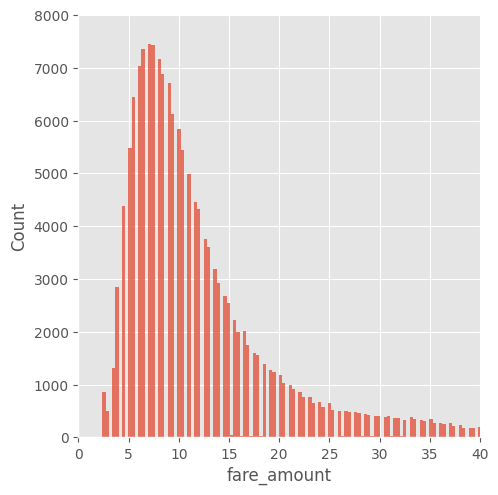

In [554]:
sns.displot(data['fare_amount'])
plt.xlim(0, 40)
plt.ylim(0, 8000)

it appears that the distribution is right tailed

In [555]:
print(data.fare_amount.max(), data.fare_amount.min())

6989.5 -111.0


In [556]:
num_columns = data._get_numeric_data().columns

In [557]:
#removing outliers to see effect on distribution
from scipy import stats
# for single column df[(np.abs(stats.zscore(df[0])) < 3)]
data = data[(np.abs(stats.zscore(data[num_columns])) < 3).all(axis=1)]

(0.0, 8000.0)

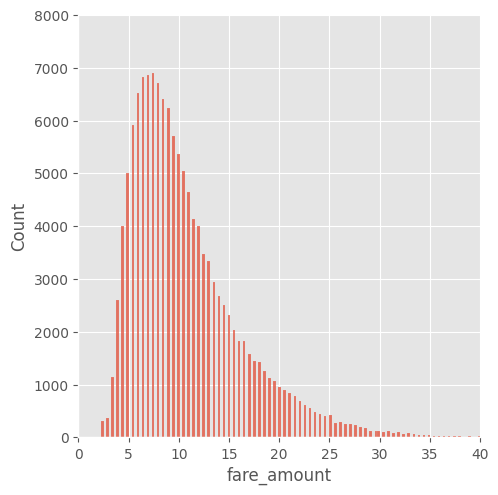

In [558]:
#checking distribution after removal of outliers
sns.displot(data['fare_amount'])
plt.xlim(0, 40)
plt.ylim(0, 8000)

(0.0, 8000.0)

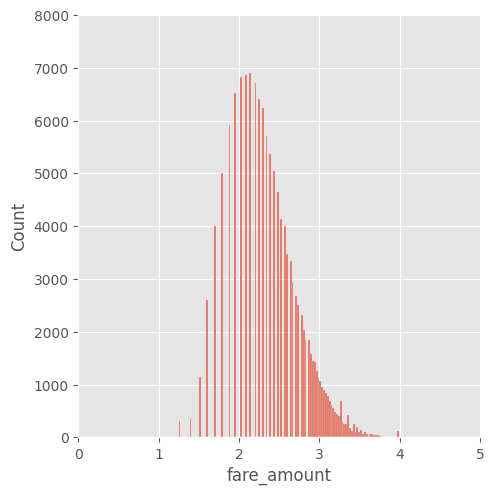

In [559]:
# does log transform help with it?
log_target = np.log1p(data['fare_amount'])
sns.displot(log_target)
plt.xlim(0, 5)
plt.ylim(0, 8000)
# much better

In [560]:
data.fare_amount.value_counts()

7.500     6910
7.000     6870
6.500     6817
8.000     6706
6.000     6520
          ... 
12.400       1
29.880       1
65.000       1
13.740       1
54.000       1
Name: fare_amount, Length: 128, dtype: int64

In [561]:
data.fare_amount.mean()

10.851567258510201

In [562]:
data.fare_amount.isna().sum()

0

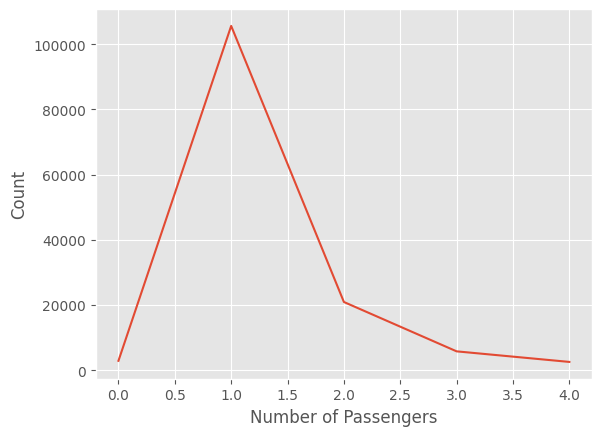

In [196]:
passenger_count = data.groupby(['passenger_count']).count()
plt.plot(passenger_count.index, passenger_count['day'])
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.show()

Most trips were solo

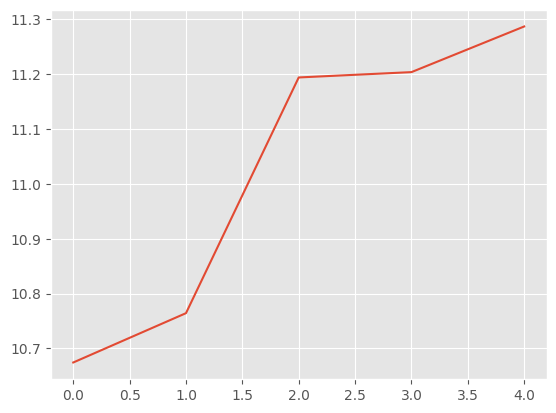

In [194]:
passenger_fare = data.groupby(['passenger_count']).mean(numeric_only=True)

plt.plot(passenger_fare.index, passenger_fare['fare_amount'])

doesnt grow much regardless of count - scale makes it look huge, but it is not

Text(0, 0.5, 'Fare Price')

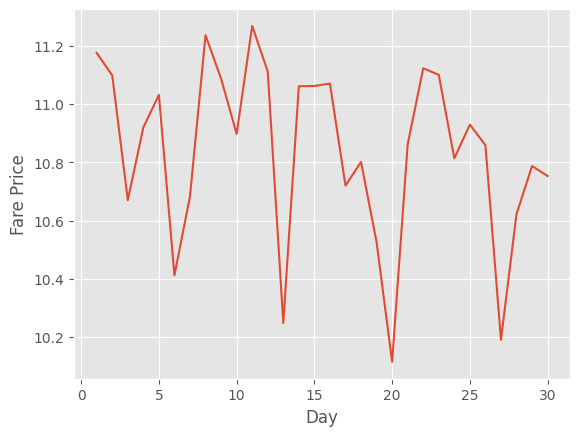

In [200]:
# day of week seems to play a part - will add 
# df['day_of_week'] = df['datecol'].dt.weekday
# maybe hour too df['hour'] = df['datecol'].dt.hour
day = data.groupby(['day']).mean(numeric_only=True)

plt.plot(day.index, day.fare_amount)

plt.xlabel('Day')
plt.ylabel('Fare Price')

Text(0, 0.5, 'Median fare amount')

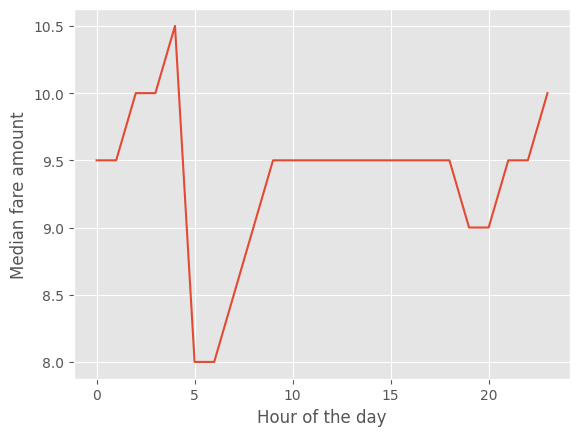

In [564]:
hour_price = data.groupby('hour', as_index=False)['fare_amount'].median()
sns.lineplot(data=hour_price, x="hour", y="fare_amount")
plt.xlabel('Hour of the day')
plt.ylabel('Median fare amount')

Text(0, 0.5, 'Fare Price')

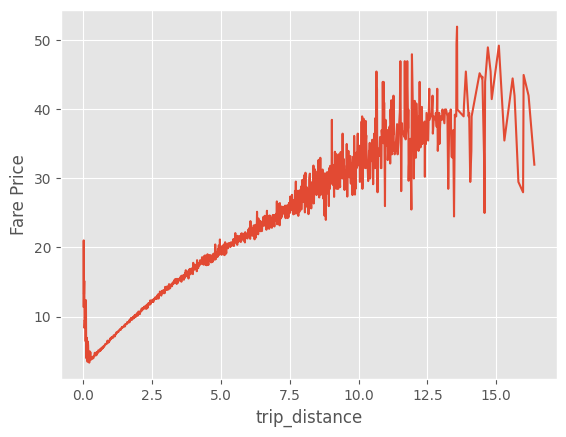

In [204]:
trip_distance = data.groupby(['trip_distance']).mean(numeric_only=True)

plt.plot(trip_distance.index, trip_distance.fare_amount)

plt.xlabel('trip_distance')
plt.ylabel('Fare Price')
#0 and negative value trips should be removed

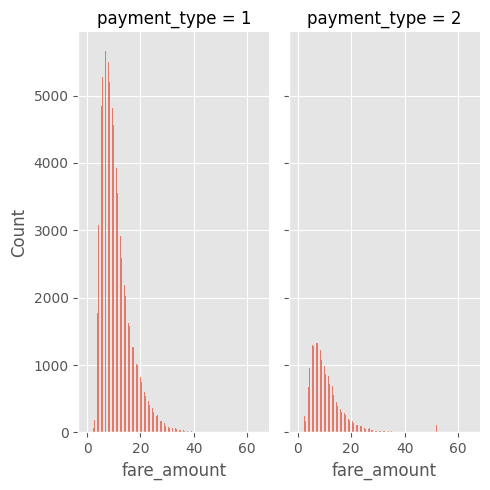

In [198]:
sns.displot(
  data=data,
  x='fare_amount',
  col="payment_type",
  kind="hist",
  aspect=0.5,
)

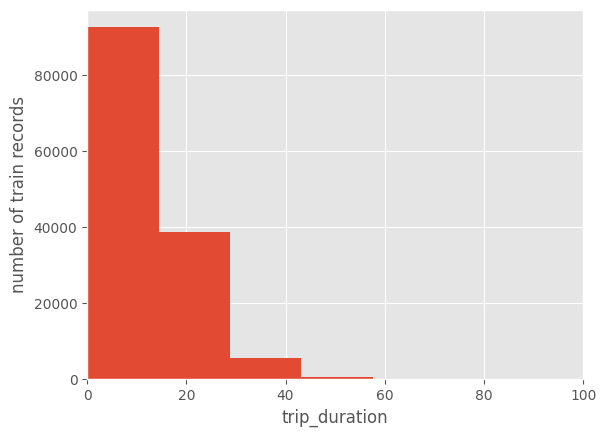

In [206]:
plt.hist(data['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.xlim(0,100)
plt.show()
#most trips under 30 minutes

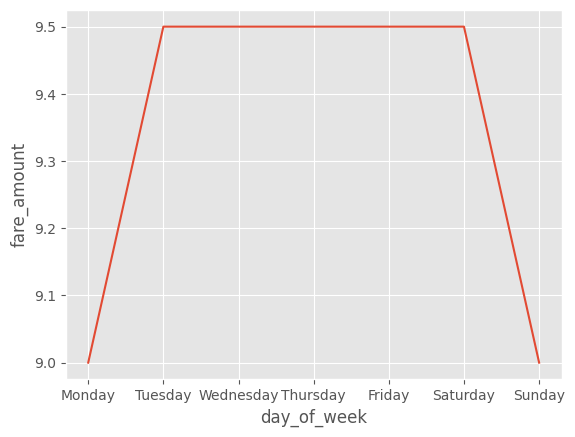

In [567]:
day_price = data.groupby('day_of_week', as_index=False)['fare_amount'].median()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.lineplot(data=day_price, x="day_of_week", y="fare_amount")
plt.xticks([0, 1, 2, 3, 4, 5, 6], days);

### Data Cleaning
constraints:
-  taxi standarad fares begin at $2.50
- latitude and longitude should not be equal to 0 & are bounded by 90 and -90

#### Handling Missing Values

In [699]:
def enforce_values(df):
    """
    Removes outliers from the data
    """
    df["trip_duration"] = df["trip_duration"][(df["trip_duration"] > 0)]
    df["passenger_count"]= df["passenger_count"][(df["passenger_count"].isin(list(range(1,8))))]
    df["VendorID"] = df["VendorID"][(df["VendorID"].isin([0,1,2]))]
    df["RatecodeID"] = df["RatecodeID"][(df["RatecodeID"].isin([0,1,2,3,4,5,6]))]
    df["payment_type"] = df["payment_type"][(df["payment_type"].isin([1,2,3,4,5,6]))]
    df = df[(df["fare_amount"] < 250) & (df["fare_amount"] >= 2.5)]
    df = df[df['pickup_lat']!= 0]
    df = df[df['pickup_long'] != 0]
    df = df[df['dropoff_lat'] != 0]
    df = df[df['dropoff_long'] != 0]
    df.dropna(inplace=True)

    return df


def keep_important_cols(df):
    cols = ['passenger_count','fare_amount', 'pickup_long', 'pickup_lat',
       'dropoff_long', 'dropoff_lat', 'trip_duration', 'day', 'month', 'year',
       'day_of_week', 'hour', 'distance', 'pickup_jfk_distance',
       'dropoff_jfk_distance', 'pickup_ewr_distance', 'dropoff_ewr_distance',
       'pickup_lga_distance', 'dropoff_lga_distance']
    df = df[cols]
    return df

def data_splitter(df, target):
    y = df[target]
    X = df.drop([target], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
                X, y, random_state=1, test_size=0.3)
    return X_train, X_test, y_train, y_test

In [682]:
df = ny_taxi_geo_merger(df, df_loc)

In [683]:
df = extra_features(df)

In [696]:
df = enforce_values(df)

In [700]:
df = keep_important_cols(df)

In [697]:
nulls = (df.isnull().sum()).loc[lambda x : x!=0]
nulls

Series([], dtype: int64)

In [701]:
df

,passenger_count,fare_amount,pickup_long,pickup_lat,dropoff_long,dropoff_lat,trip_duration,day,month,year,day_of_week,hour,distance,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
0,1.000,7.000,-73.997,40.729,-73.986,40.749,8.000,8,6,2022,2,18,1.426,20.895,21.263,14.999,16.656,11.813,10.028
1,1.000,21.000,-73.972,40.757,-73.894,40.740,26.000,21,6,2022,1,9,8.756,20.885,14.794,18.016,23.760,8.713,4.498
2,1.000,8.000,-73.973,40.792,-73.988,40.776,9.000,8,6,2022,2,14,1.785,23.537,23.265,19.840,17.787,8.611,9.759
3,1.000,14.500,-73.973,40.792,-74.000,40.748,19.000,13,6,2022,0,15,3.273,23.537,22.219,19.840,15.522,8.611,11.194
4,1.000,12.500,-73.995,40.732,-73.985,40.695,16.000,4,6,2022,5,18,1.561,20.929,18.481,15.292,15.463,11.462,13.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178095,3.000,6.500,-74.004,40.752,-73.990,40.762,7.000,18,6,2022,5,12,1.583,22.736,22.409,15.408,16.949,11.393,10.015
178096,6.000,8.500,-73.965,40.757,-73.957,40.780,8.000,25,6,2022,5,14,1.152,20.378,21.692,18.585,20.340,8.116,7.118
178097,1.000,5.000,-74.000,40.748,-74.000,40.748,3.000,28,6,2022,1,17,0.000,22.219,22.219,15.522,15.522,11.194,11.194
178098,1.000,18.000,-73.988,40.776,-73.978,40.748,28.000,8,6,2022,2,17,1.479,23.265,20.623,17.787,17.231,9.759,9.439


### Modeling & Feature Analysis
First we will train some models, and assess feature importance, and then we will play with model parameters after adjusting the features

In [399]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.decomposition import PCA
set_config(display='diagram')

In [861]:
ordinal_columns = ["month", "day_of_week", "passenger_count"]

def reset_data(frac=0.05):
    df = pd.read_parquet('yellow_tripdata_2022-06.parquet')
    df = df.sample(frac=frac)
    df = ny_taxi_geo_merger(df, df_loc)
    df = extra_features(df)
    df = enforce_values(df)
    df = impute_cols(df)
    df = keep_important_cols(df)
    X_train, X_test, y_train, y_test = data_splitter(df, "fare_amount")
    return X_train, X_test, y_train, y_test

#### Baseline Models

In [764]:
scores = pd.DataFrame(columns=['model', 'RMSE', 'score'])
def train_model(model):
    X_train, X_test, y_train, y_test = reset_data()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    score = model.score(X_test, y_pred)
    row = [str(model), rmse, score]
    scores.loc[len(scores)] = row
    return model

#### Linear Regression

In [767]:
lr = train_model(LinearRegression())

In [763]:
pd.DataFrame({"Feature":X_train.columns.tolist(),"Coefficients":lr.coef_[0]})

,Feature,Coefficients
0,passenger_count,0.104
1,pickup_long,0.104
2,pickup_lat,0.104
3,dropoff_long,0.104
4,dropoff_lat,0.104
5,trip_duration,0.104
6,day,0.104
7,month,0.104
8,year,0.104
9,day_of_week,0.104


#### RandomForestRegressor

In [765]:
rf = train_model(RandomForestRegressor())

In [768]:
scores

,model,RMSE,
0,RandomForestRegressor(),2.736,1.000
1,LinearRegression(),4.799,1.000


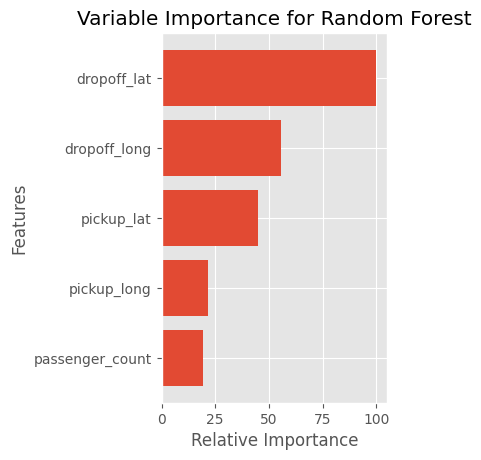

In [772]:
feature_importance = rf.feature_importances_[:5]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()

#### GradientBoostingRegressor

In [773]:
GBR = train_model(GradientBoostingRegressor())

In [774]:
scores

,model,RMSE,
0,RandomForestRegressor(),2.736,1.000
1,LinearRegression(),4.799,1.000
2,GradientBoostingRegressor(),2.532,1.000


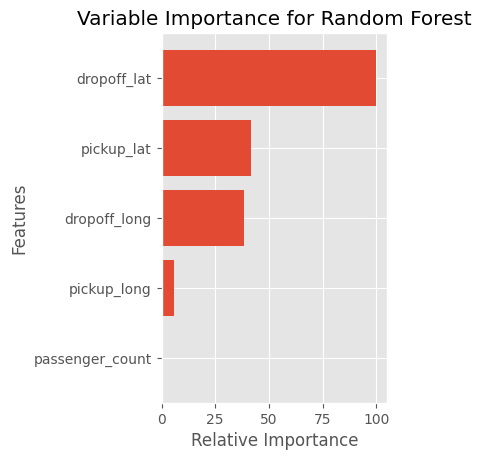

In [775]:
feature_importance = GBR.feature_importances_[:5]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx]) 
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Variable Importance for Random Forest')
plt.show()

#### LGBM

In [803]:
import lightgbm as lgbm

In [804]:
lgbm_model = train_model(lgbm.LGBMRegressor())

In [805]:
scores

,model,RMSE,
0,RandomForestRegressor(),2.736,1.000
1,LinearRegression(),4.799,1.000
2,GradientBoostingRegressor(),2.532,1.000
3,"XGBRegressor(base_score=0.5, booster='gbtree',...",2.457,1.000
4,LGBMRegressor(),2.566,1.000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

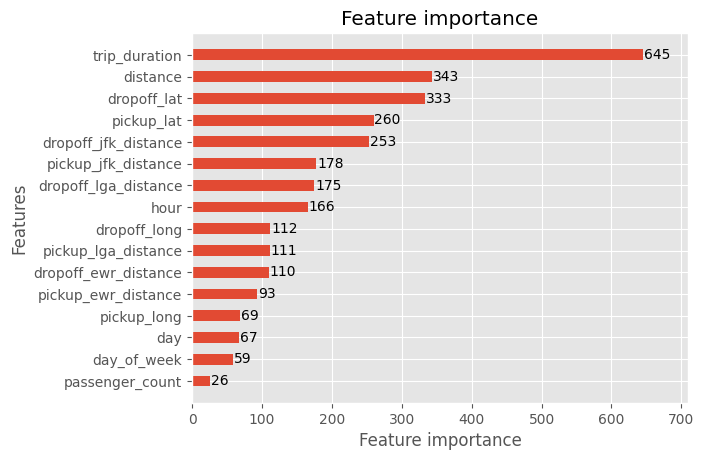

In [828]:
lgbm.plot_importance(lgbm_model, height=.5)

#### XGBOOST

In [489]:
import xgboost as xgb
from xgboost import plot_importance

In [777]:
XGB = train_model(xgb.XGBRegressor())

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

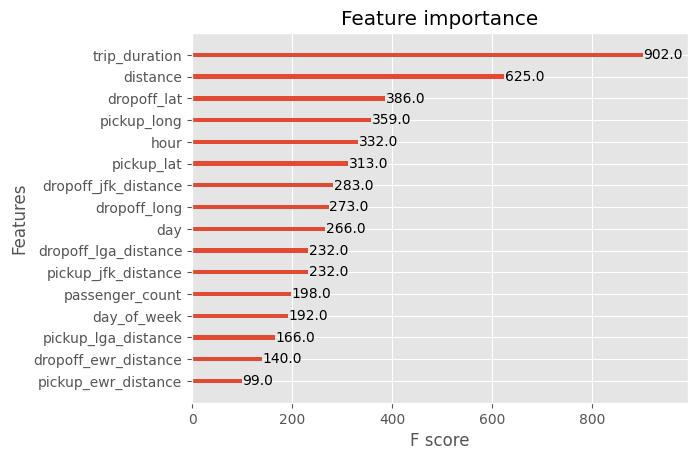

In [779]:
plot_importance(XGB)

In [780]:
scores

,model,RMSE,
0,RandomForestRegressor(),2.736,1.000
1,LinearRegression(),4.799,1.000
2,GradientBoostingRegressor(),2.532,1.000
3,"XGBRegressor(base_score=0.5, booster='gbtree',...",2.457,1.000


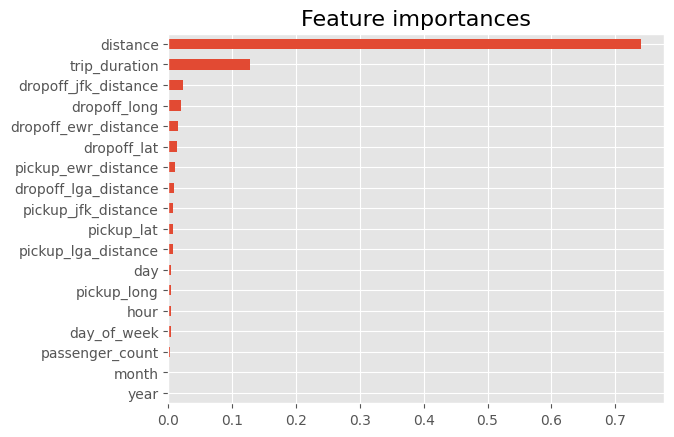

In [798]:
pd.DataFrame(XGB.feature_importances_, index = X_train.columns).sort_values(0)\
.plot(kind = 'barh', legend = False)
plt.title('Feature importances', fontsize = 16);

### Hyperparameter Tuning

In [854]:
scores = pd.DataFrame(columns=['model', 'untuned_RMSE', 'untuned_score', 'tuned_RMSE', 'tuned_score', \
                               'gridsearch_best_estimator', 'best_score', 'best_params'])
def train_model(model, params):
    X_train, X_test, y_train, y_test = reset_data()
    model.fit(X_train, y_train)
    y_pred_untuned = model.predict(X_test)
    untuned_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_untuned))
    untuned_score = model.score(X_test, y_pred_untuned)
    
    #tuning
    grid_search = GridSearchCV(estimator=model, param_grid = params, cv = 2, n_jobs=8)
    grid_search.fit(X_train, y_train)
    try: 
        gridsearch_best_estimator = grid_search.best_estimator_
    except: 
        gridsearch_best_estimator = "None"
    
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    tuned_y_pred = grid_search.predict(X_test)
    tuned_RMSE = np.sqrt(metrics.mean_squared_error(y_test, tuned_y_pred))
    tuned_score = grid_search.score(X_test, tuned_y_pred)
    row = [str(model), untuned_RMSE, untuned_score, \
           tuned_RMSE, tuned_score, \
           str(gridsearch_best_estimator),best_score, str(best_params)]
    scores.loc[len(scores)] = row
    print(best_params)
    print(best_score)
    print(tuned_RMSE)
    print(untuned_RMSE, tuned_RMSE)
    return grid_search

#### LR

In [814]:
grid_params = {"normalize": [True, False],
              "fit_intercept": [True, False],}
train_model(LinearRegression(), grid_params)

GridSearchCV(cv=2, estimator=LinearRegression(), n_jobs=8,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [815]:
scores

,model,untuned_RMSE,untuned_score,tuned_RMSE,tuned_score,gridsearch_best_estimator,best_score,best_params
0,LinearRegression(),4.836,1.000,4.836,1.000,LinearRegression(normalize=True),0.838,"{'fit_intercept': True, 'normalize': True}"


In [819]:
X_train, X_test, y_train, y_test = reset_data()
model = LinearRegression(fit_intercept =True, normalize =True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print(score, RMSE)

1.0 4.946520201096433


#### RFR

In [822]:
parameters={
    "n_estimators": [5,20,50,100],
    "max_features": ["auto", "sqrt"],
    "bootstrap": [True, False],
    "max_depth" : [1,3,5,7,9,11,12],
    "min_samples_leaf":[1,3,4],}
train_model(RandomForestRegressor(), parameters)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 4],
                         'n_estimators': [5, 20, 50, 100]})

In [824]:
scores

,model,untuned_RMSE,untuned_score,tuned_RMSE,tuned_score,gridsearch_best_estimator,best_score,best_params
0,LinearRegression(),4.836,1.000,4.836,1.000,LinearRegression(normalize=True),0.838,"{'fit_intercept': True, 'normalize': True}"
1,RandomForestRegressor(),2.702,1.000,2.735,1.000,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.954,"{'bootstrap': True, 'max_depth': 12, 'max_feat..."


#### GradientBoostingRegressor

In [825]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [5,100,500,1000, 1500],
              'max_depth'    : [4,6,8,10] }

train_model(GradientBoostingRegressor(), parameters)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [5, 100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [827]:
scores

,model,untuned_RMSE,untuned_score,tuned_RMSE,tuned_score,gridsearch_best_estimator,best_score,best_params
0,LinearRegression(),4.836,1.000,4.836,1.000,LinearRegression(normalize=True),0.838,"{'fit_intercept': True, 'normalize': True}"
1,RandomForestRegressor(),2.702,1.000,2.735,1.000,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.954,"{'bootstrap': True, 'max_depth': 12, 'max_feat..."
2,GradientBoostingRegressor(),2.556,1.000,2.393,1.000,([DecisionTreeRegressor(criterion='friedman_ms...,0.955,"{'learning_rate': 0.02, 'max_depth': 4, 'n_est..."


#### LGBM

In [829]:
parameters = {
        "device_type": ['gpu'],
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],

    }
lgbm_reg = train_model(lgbm.LGBMRegressor(), parameters)

GridSearchCV(cv=2, estimator=LGBMRegressor(), n_jobs=8,
             param_grid={'device_type': ['gpu'],
                         'learning_rate': [0.1, 0.03, 0.003],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [7, 14, 21, 28, 31, 50]})

In [830]:
scores

,model,untuned_RMSE,untuned_score,tuned_RMSE,tuned_score,gridsearch_best_estimator,best_score,best_params
0,LinearRegression(),4.836,1.000,4.836,1.000,LinearRegression(normalize=True),0.838,"{'fit_intercept': True, 'normalize': True}"
1,RandomForestRegressor(),2.702,1.000,2.735,1.000,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.954,"{'bootstrap': True, 'max_depth': 12, 'max_feat..."
2,GradientBoostingRegressor(),2.556,1.000,2.393,1.000,([DecisionTreeRegressor(criterion='friedman_ms...,0.955,"{'learning_rate': 0.02, 'max_depth': 4, 'n_est..."
3,LGBMRegressor(),2.513,1.000,2.485,1.000,"LGBMRegressor(device_type='gpu', learning_rate...",0.951,"{'device_type': 'gpu', 'learning_rate': 0.03, ..."


### XGBOOST

In [836]:
param = {
    'tree_method':['gpu_hist'], 
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 500],
    'colsample_bytree': [0.2, 0.6, 0.8],
    'min_child_weight': [3, 5, 7],
    'gamma': [0.3, 0.5, 0.7],
    'subsample': [0.4, 0.6, 0.8]
}


XGB = train_model(xgb.XGBRegressor(), param)

In [837]:
scores

,model,untuned_RMSE,untuned_score,tuned_RMSE,tuned_score,gridsearch_best_estimator,best_score,best_params
0,LinearRegression(),4.836,1.000,4.836,1.000,LinearRegression(normalize=True),0.838,"{'fit_intercept': True, 'normalize': True}"
1,RandomForestRegressor(),2.702,1.000,2.735,1.000,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.954,"{'bootstrap': True, 'max_depth': 12, 'max_feat..."
2,GradientBoostingRegressor(),2.556,1.000,2.393,1.000,([DecisionTreeRegressor(criterion='friedman_ms...,0.955,"{'learning_rate': 0.02, 'max_depth': 4, 'n_est..."
3,LGBMRegressor(),2.513,1.000,2.485,1.000,"LGBMRegressor(device_type='gpu', learning_rate...",0.951,"{'device_type': 'gpu', 'learning_rate': 0.03, ..."
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",2.544,1.000,2.560,1.000,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.954,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'max_d..."


**Best Model appears to be the GradientBoostingRegressor, however XGB performs more consistently**

#### train on full dataset

In [859]:
params = XGB.best_params_

In [864]:
%%time
model = xgb.XGBRegressor(params = params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
score = model.score(X_test, y_pred)

print(f"RMSE: {RMSE}\nScore:{score}")

[13:12:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 2.3820999501802667
Score:1.0
CPU times: total: 21min 10s
Wall time: 1min 30s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

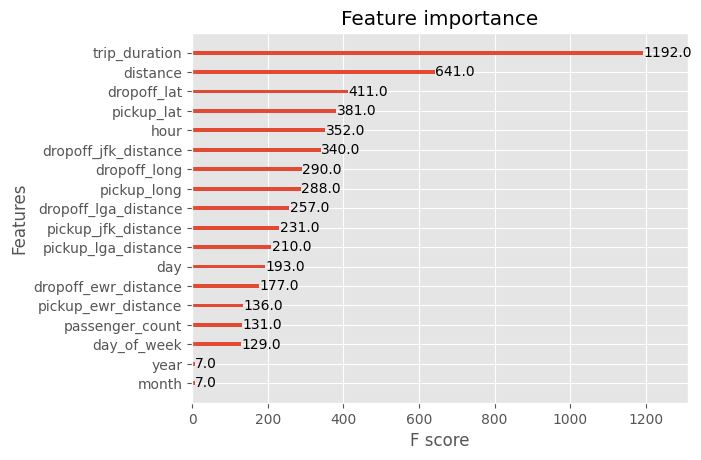

In [865]:
plot_importance(model)

### Defining A functin to take input 

In [871]:
import requests
import json

#test
lon_1 = -74.172
lat = 40.689 
lon_2 = -74.188
lat_2 = 40.551
# call the OSMR API
r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lon_1},{lat};{lon_2},{lat_2}?overview=false""")
# then you load the response using the json libray
# by default you get only one alternative so you access 0-th element of the `routes`
routes = json.loads(r.content)
route_1 = routes.get("routes")[0]['duration']

In [874]:
trip_duration = route_1/60
trip_duration

24.69

**trip duration plays a role, however the user cannot give that as input, so using an API to get a reasonable guess helps with the prediction, now user only has to enter pick up and drop of zones**

In [879]:
# shape file specific for this scenario
sf = shapefile.Reader("3/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_zones= pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_zones.drop(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'LocationID', 'borough'], inplace=True, axis=1)
df_zones

,zone,longitude,latitude
0,Newark Airport,-74.172,40.689
1,Jamaica Bay,-73.822,40.611
2,Allerton/Pelham Gardens,-73.845,40.866
3,Alphabet City,-73.978,40.724
4,Arden Heights,-74.188,40.551
...,...,...,...
258,Woodlawn/Wakefield,-73.856,40.899
259,Woodside,-73.907,40.747
260,World Trade Center,-74.013,40.709
261,Yorkville East,-73.945,40.777


In [880]:
df_zones.to_csv('prediction_zones.csv', index=None)

In [884]:
X_train.columns

Index(['passenger_count', 'pickup_long', 'pickup_lat', 'dropoff_long',
       'dropoff_lat', 'trip_duration', 'day', 'month', 'year', 'day_of_week',
       'hour', 'distance', 'pickup_jfk_distance', 'dropoff_jfk_distance',
       'pickup_ewr_distance', 'dropoff_ewr_distance', 'pickup_lga_distance',
       'dropoff_lga_distance'],
      dtype='object')

In [883]:
import bentoml

In [886]:
import datetime

In [1053]:
data = {
    "passenger_count": 1,
    "pickup_zone": "Yorkville East",
    "dropoff_zone": "Yorkville West"
}

In [1075]:
class PredictionAssistant:
    """
    data comes in form
    passenger_count
    pickup_zone
    dropoff
    """
    df2 = pd.read_csv('prediction_zones.csv')
    
    now = datetime.datetime.now()
    def __init__(self, inputs):
        self.inputs = inputs
        self.df1 = pd.DataFrame([self.inputs])

    
    
    def get_trip_duration(self, df):
        r = requests.get(f"http://router.project-osrm.org/route/v1/car/{df.pickup_long[0]},{df.pickup_lat[0]};{df.dropoff_long[0]},{df.dropoff_lat[0]}?overview=false""")
        routes = json.loads(r.content)
        trip_duration = routes.get("routes")[0]['duration']
        trip_duration = trip_duration/60
        return trip_duration
    
    def get_distance(self, s_lat, s_lng, e_lat, e_lng):
       # approximate radius of earth in km
       R = 6373.0

       s_lat = s_lat*np.pi/180.0                      
       s_lng = np.deg2rad(s_lng)     
       e_lat = np.deg2rad(e_lat)                       
       e_lng = np.deg2rad(e_lng)  

       d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

       return 2 * R * np.arcsin(np.sqrt(d))
    
    def add_distances_from_airport(self, df):
        #coordinates of all these airports
        jfk_coords = (40.639722, -73.778889)
        ewr_coords = (40.6925, -74.168611)
        lga_coords = (40.77725, -73.872611)

        df['pickup_jfk_distance'] = self.get_distance(jfk_coords[0], jfk_coords[1], df.pickup_lat, df.pickup_long)
        df['dropoff_jfk_distance'] = self.get_distance(jfk_coords[0], jfk_coords[1], df.dropoff_lat, df.dropoff_long)

        df['pickup_ewr_distance'] = self.get_distance(ewr_coords[0], ewr_coords[1], df.pickup_lat, df.pickup_long)
        df['dropoff_ewr_distance'] = self.get_distance(ewr_coords[0], ewr_coords[1], df.dropoff_lat, df.dropoff_long)

        df['pickup_lga_distance'] = self.get_distance(lga_coords[0], lga_coords[1], df.pickup_lat, df.pickup_long)
        df['dropoff_lga_distance'] = self.get_distance(lga_coords[0], lga_coords[1], df.dropoff_lat, df.dropoff_long)

        return df

        
    def merge_geo(self, df1, df2, left_on):
        prefix = left_on.split('_')[0]
        df = pd.merge(df1, df2, how="left", left_on=[left_on], right_on=['zone'] )
        df.rename(columns = {"longitude": f"{prefix}_long", "latitude":f'{prefix}_lat' }, 
              inplace = True)
        df.drop(['zone', left_on], axis=1, inplace=True)
        return df
    
    
    def run(self):
        df = self.merge_geo(self.df1, df2,'pickup_zone')
        df = self.merge_geo(df, df2, 'dropoff_zone')
        df['trip_duration'] = self.get_trip_duration(df)
        df['day'] = now.day
        df['month'] = now.month
        df['year'] = now.year
        df['day_of_week'] = now.weekday()
        df['hour'] = now.hour
        df['distance'] =self.get_distance(df.pickup_long, df.pickup_lat, df.dropoff_long, df.dropoff_lat)
        df = self.add_distances_from_airport(df)
        return df
    

In [1055]:
test = PredictionAssistant(data)
test.df1

,passenger_count,pickup_zone,dropoff_zone
0,1,Yorkville East,Yorkville West


In [1056]:
s = test.run()

In [1057]:
s.dtypes

passenger_count           int64
pickup_long             float64
pickup_lat              float64
dropoff_long            float64
dropoff_lat             float64
trip_duration           float64
hour                      int64
day                       int64
month                     int64
year                      int64
day_of_week               int64
distance                float64
pickup_jfk_distance     float64
dropoff_jfk_distance    float64
pickup_ewr_distance     float64
dropoff_ewr_distance    float64
pickup_lga_distance     float64
dropoff_lga_distance    float64
dtype: object

In [1059]:
model.predict(s)[0]

4.4952326

In [1076]:
bentoml.xgboost.save_model("ny_taxi_model", model, custom_objects={
    "prediction_assistant": PredictionAssistant})

Model(tag="ny_taxi_model:zuxnagc3qolf3bfj", path="C:\Users\Kawba\bentoml\models\ny_taxi_model\zuxnagc3qolf3bfj\")

In [1072]:
X_train.columns

Index(['passenger_count', 'pickup_long', 'pickup_lat', 'dropoff_long',
       'dropoff_lat', 'trip_duration', 'day', 'month', 'year', 'day_of_week',
       'hour', 'distance', 'pickup_jfk_distance', 'dropoff_jfk_distance',
       'pickup_ewr_distance', 'dropoff_ewr_distance', 'pickup_lga_distance',
       'dropoff_lga_distance'],
      dtype='object')

In [1071]:
len(s.columns) == len(X_train.columns)

True

#### Testing

In [1124]:
class doubleQuoteDict(dict):
    def __str__(self):
        return json.dumps(self)

    def __repr__(self):
        return json.dumps(self)
x = ((df_zones.sample())['zone'].to_string(index=False))
y = ((df_zones.sample())['zone'].to_string(index=False))
passenger_count = np.random.randint(8)
pairs = [
           ['passenger_count', passenger_count], 
           ['pickup_zone', x], 
           ['dropoff_zone', y], 
          ]
pairs = doubleQuoteDict(pairs)
print(pairs)

{"passenger_count": 7, "pickup_zone": "Morrisania/Melrose", "dropoff_zone": "West Village"}


In [1119]:
df_zones

,zone,longitude,latitude
0,Newark Airport,-74.172,40.689
1,Jamaica Bay,-73.822,40.611
2,Allerton/Pelham Gardens,-73.845,40.866
3,Alphabet City,-73.978,40.724
4,Arden Heights,-74.188,40.551
...,...,...,...
258,Woodlawn/Wakefield,-73.856,40.899
259,Woodside,-73.907,40.747
260,World Trade Center,-74.013,40.709
261,Yorkville East,-73.945,40.777
